<a href="https://colab.research.google.com/github/bmoretz/MSDS-MachineLearning/blob/master/Assignment_07/Assignment_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workspace Initialization

## Libraries & Standard Setup

In [0]:
!pip install jupyterthemes

In [0]:
!pip install -U -q PyDrive

In [0]:
%matplotlib inline

import os
import io

# Core
import pandas as pd
import numpy as np

# Visuals
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# jt themes
from jupyterthemes import jtplot

# Display Images
from PIL import Image, ImageFilter

# IPython display
from IPython.display import display

# Loading Zip Files
import zipfile

# Working with images
import cv2

# Progress Bar (for long processes)
from tqdm import tqdm

In [0]:
import tensorflow as tf
import time

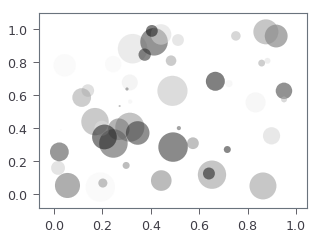

In [0]:
# Test Theme
!jt -t grade3 -f fira -fs 115
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Looks good. Let's roll.

## Globals

In [0]:
RANDOM_SEED = 42

IMG_WIDTH = 75
IMG_HEIGHT = 75
IMG_CHANNELS = 1

IMG_SHAPE = [IMG_WIDTH, IMG_HEIGHT]
IMG_LENGTH = IMG_WIDTH * IMG_HEIGHT

Function to make output stable across runs.

In [0]:
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Project Dataset

## Cats Vs. Dogs Training Data

Load the cats vs. dogs dataset from mounted drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def label_img(img_name):
  if 'cat' in img_name: return [1, 0]
  elif 'dog' in img_name: return [0, 1]

In [0]:
training_data = []

with zipfile.ZipFile('/content/drive/My Drive/datasets/cats_vs_dogs/train.zip', 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (IMG_WIDTH, IMG_HEIGHT))

      training_data.append([ np.array(img), np.array(label)])

100%|██████████| 25001/25001 [00:32<00:00, 772.06it/s]


## Data Set Exploration

In [0]:
training_data[0]

[array([[168, 174, 177, ..., 211, 208, 205],
        [168, 174, 177, ..., 213, 209, 206],
        [168, 174, 177, ..., 216, 210, 208],
        ...,
        [127, 129, 132, ...,   3,   3,   2],
        [126, 128, 131, ...,   3,   3,   3],
        [123, 125, 129, ...,   2,   2,   2]], dtype=uint8), array([1, 0])]

### Graphical Utility

Peek an image and it's label from the training data.

In [0]:
def peek_img( index, data = training_data):
  img_type = 'Unknown'
  
  if np.array_equal(data[index][1], [1, 0]): img_type = 'Cat'
  elif np.array_equal(data[index][1], [0, 1]): img_type = 'Dog'
  
  imshow(data[index][0], cmap = 'gray', interpolation = 'bicubic')
  plt.title(img_type)
  plt.show()

Show an image in grey scale format.

### Raw Image Data

Let's explore some of the training data. We'll start with the first image in the set in its raw form.

In [0]:
training_data[0][0]

array([[168, 174, 177, ..., 211, 208, 205],
       [168, 174, 177, ..., 213, 209, 206],
       [168, 174, 177, ..., 216, 210, 208],
       ...,
       [127, 129, 132, ...,   3,   3,   2],
       [126, 128, 131, ...,   3,   3,   3],
       [123, 125, 129, ...,   2,   2,   2]], dtype=uint8)

### Graphical Version

Now, let's view the actual image.

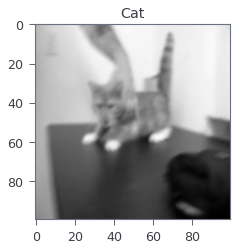

In [0]:
peek_img(0)

### Label verification

Now let's find a dog and make sure it's labeled correctly. Let's find the first 'dog' label.

In [0]:
dog_index = -1

for i, x in enumerate(training_data):
  if np.array_equal(x[1], [0, 1]):
    dog_index = i
    break

dog_index

12500

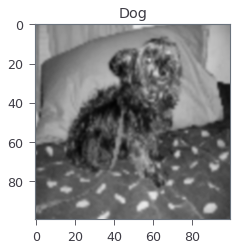

In [0]:
peek_img(dog_index)

Let's get some random images from the set and display their image & training label.

In [0]:
def plot_images(images, cls_true, indexes = None, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=1.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(IMG_SHAPE), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis, and the image index on the y-axis.
        ax.set_xlabel(xlabel)
        
        if indexes != None:
          ax.set_ylabel(indexes[i])
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
def plot_indexes(indexes):
  subset = [training_data[i] for i in indexes]

  images = []
  labels = []

  for i in subset:
    x, y = i

    images.append(x)

    if np.array_equal(y, [1, 0]): labels.append('Cat')
    elif np.array_equal(y, [0, 1]): labels.append('Dog')

  plot_images(images, labels, indexes)

Get some random indices.

In [0]:
import random

indexes = []

for x in range(9):
  indexes.append(random.randint(0, len(training_data)))

Show some random images from the training data.

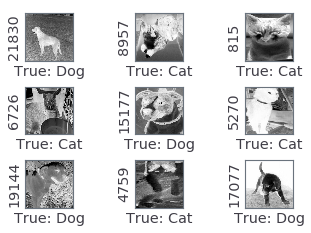

In [0]:
plot_indexes(indexes)

Shuffel the training data.

In [0]:
from random import shuffle 

shuffle(training_data)

Replot the same indexes to ensure shuffeling occured.

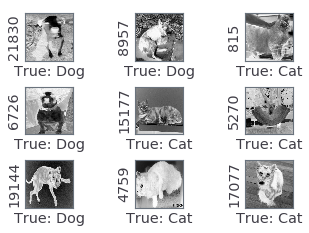

In [0]:
plot_indexes(indexes)

## Split Train & Test

In [0]:
train_size = int(len(training_data) * .8)
train_size

20000

In [0]:
train = training_data[-train_size:]
display('Train Size: {}'.format(len(train)))

test = training_data[:-train_size]
display('Test Size: {}'.format(len(test)))

'Train Size: 20000'

'Test Size: 5000'

Training data.

In [0]:
X_train = np.array([i[0] for i in train]).reshape(-1,IMG_WIDTH, IMG_HEIGHT,1)
y_train = np.array([i[1] for i in train])

Testing data.

In [0]:
X_test = np.array([i[0] for i in test]).reshape(-1,IMG_WIDTH, IMG_HEIGHT,1)
y_test = np.array([i[1] for i in test])

# Deep Classification Model

## Model Variables

Model Learning Rate

In [0]:
LR = 1e-3

Model Name

In [0]:
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic')

## TensorFlow

In [0]:
!pip install tflearn

In [0]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

## Model Versions

In [0]:
def get_model_baseline():
  convnet = input_data(shape=[None, IMG_WIDTH, IMG_HEIGHT, 1], name='input')

  convnet = conv_2d(convnet, 32, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 64, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = fully_connected(convnet, 1024, activation='relu')
  convnet = dropout(convnet, 0.8)

  convnet = fully_connected(convnet, 2, activation='softmax')
  convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

  return tflearn.DNN(convnet, tensorboard_dir='log')

In [0]:
def get_model_v2():
  convnet = input_data(shape=[None, IMG_WIDTH, IMG_HEIGHT, 1], name='input')

  convnet = conv_2d(convnet, 32, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 64, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 128, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 64, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = conv_2d(convnet, 32, 5, activation='relu')
  convnet = max_pool_2d(convnet, 5)

  convnet = fully_connected(convnet, 1024, activation='relu')
  convnet = dropout(convnet, 0.8)

  convnet = fully_connected(convnet, 2, activation='softmax')
  convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

  return tflearn.DNN(convnet, tensorboard_dir='log')

### Model Fit

In [0]:
display('Train Size: {}'.format(len(X_train)))

'Train Size: 20000'

Reset graph to default state & train on selected data set.

In [0]:
reset_graph()

model_baseline = get_model_baseline()

start_time = time.clock()

model_baseline.fit({'input': X_train}, {'targets': y_train}, n_epoch=3, validation_set=({'input': X_test}, {'targets': y_test}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

end_time = time.clock()

runtime = end_time - start_time  # seconds of wall-clock time 

Training Step: 938  | total loss: 11.70753 | time: 276.133s
| Adam | epoch: 003 | loss: 11.70753 - acc: 0.4915 -- iter: 19968/20000
Training Step: 939  | total loss: 11.58014 | time: 302.967s
| Adam | epoch: 003 | loss: 11.58014 - acc: 0.4971 | val_loss: 11.69253 - val_acc: 0.4922 -- iter: 20000/20000
--


In [0]:
display('Model Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model Train Time: 17.95 minutes'

Reset graph to default state & train on selected data set.

In [0]:
reset_graph()

model_v2 = get_model_v2()

start_time = time.clock()

model_v2.fit({'input': X_train}, {'targets': y_train}, n_epoch=3, validation_set=({'input': X_test}, {'targets': y_test}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

end_time = time.clock()

runtime = end_time - start_time  # seconds of wall-clock time 

Training Step: 938  | total loss: 0.41723 | time: 295.821s
| Adam | epoch: 003 | loss: 0.41723 - acc: 0.8065 -- iter: 19968/20000
Training Step: 939  | total loss: 0.42124 | time: 321.158s
| Adam | epoch: 003 | loss: 0.42124 - acc: 0.8071 | val_loss: 0.46501 - val_acc: 0.7828 -- iter: 20000/20000
--


In [0]:
display('Model Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model Train Time: 18.94 minutes'

# Validation

Load our testing data.

In [0]:
test_data = []

with zipfile.ZipFile('/content/drive/My Drive/datasets/cats_vs_dogs/test1.zip', 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (IMG_WIDTH, IMG_HEIGHT))

      test_data.append([ np.array(img), np.array(label)])

100%|██████████| 12501/12501 [00:16<00:00, 754.70it/s]


Run our model against some test data.

## Visual Inspection

In [0]:
import matplotlib.pyplot as plt

def visual_inspect_model( model ):
  fig=plt.figure(figsize=(5,5))
  fig.subplots_adjust(hspace=0.5, wspace=1.3)

  for num,data in enumerate(test_data[:12]):

      img_num = data[1]
      img_data = data[0]

      y = fig.add_subplot(4,3,num+1)
      orig = img_data
      data = img_data.reshape(IMG_WIDTH,IMG_HEIGHT,1)

      model_out = model.predict([data])[0]

      if np.argmax(model_out) == 1: str_label='Dog'
      else: str_label='Cat'

      y.imshow(orig,cmap='gray')
      plt.title(str_label)
      y.axes.get_xaxis().set_visible(False)
      y.axes.get_yaxis().set_visible(False)

  plt.show()

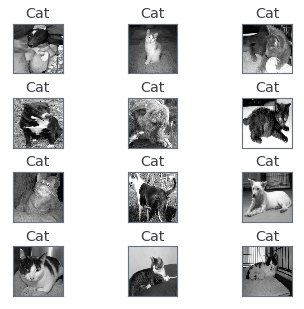

In [0]:
visual_inspect_model(model_baseline)

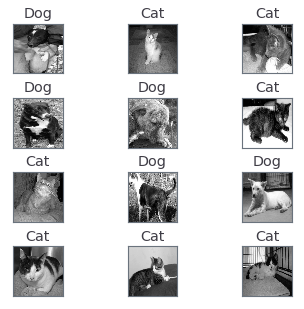

In [0]:
visual_inspect_model(model_v2)

## Test Data Summary

In [0]:
def validate_model(model):
  total = len(X_test)
  correct = 0

  for num, data in enumerate(X_test):
    y_pred = model.predict([data])[0]

    if np.argmax(y_pred) == 1: img_pred='Dog'
    else: img_pred='Cat'

    if np.array_equal(y_test[num], [1, 0]): img_actual = 'Cat'
    elif np.array_equal(y_test[num], [0, 1]): img_actual = 'Dog'

    if img_actual == img_pred:
      correct = correct + 1

  display('Total Test Images: {}, Correctly Predicted: {}, {:.2%}'.format(total, correct, correct / total))

In [0]:
validate_model(model_baseline)

'Total Test Images: 5000, Correctly Predicted: 2461, 49.22%'

In [0]:
validate_model(model_v2)

'Total Test Images: 5000, Correctly Predicted: 3914, 78.28%'